## Training GPT-2 Model on Path Sequences to Perform Navigation Tasks
This script trains/fine-tunes a GPT-2 model on path sequences in artificial grid environments with randomly generated nouns representing locations on a grid.

This script has the following parts:

* Generation of path sequences in artificial environments
Optimal paths and suboptimal paths are separately generated in the training data. For optimal paths, the shortest paths from any starting and ending locations are generated, therefore the training data includes all the possible optimal paths. For suboptimal paths, only a subset is randomly selected, because the number of possible suboptimal paths greatly outnumber optimal paths as the grid size increases. 

* Train/fine-tune GPT-2 model on the generated path sequences




#### Installation / imports:

In [1]:
# # Connect to Google drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/My Drive/modelling_spatial_navigation/gpt2small_dual_mode_v12_6000_4by4grids"

In [2]:
# python and pip version check
! which python
! which pip
! python --version

/cs/student/projects1/aibh/2024/cbaumgar/.venv/bin/python
/cs/student/projects1/aibh/2024/cbaumgar/.venv/bin/pip
Python 3.9.21


In [3]:
! pip install git+https://github.com/huggingface/transformers --upgrade
! pip install accelerate evaluate wonderwords simpletransformers --upgrade
! pip install huggingface_hub --upgrade

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-w6wu31ub
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-w6wu31ub
  Resolved https://github.com/huggingface/transformers to commit d7b87b415a5dd4a3152051e1a0abd098a02c5bfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 53.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731

### Generate training and test data.

In [3]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from itertools import permutations
import logging
from random import shuffle
from matplotlib import pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import math

os.environ["WANDB_DISABLED"] = "true"

Random_Word = RandomWord()

# Function to generate a random grid of nouns
def create_unique_random_grid(nouns, size):
    random_nouns = random.sample(nouns, size * size)
    return [random_nouns[i * size:(i + 1) * size] for i in range(size)]

# Function to generate all start-end combinations for a given grid
def generate_start_end_permutations(size):
    combinations = []
    for start_x in range(size):
        for start_y in range(size):
            for end_x in range(size):
                for end_y in range(size):
                    if (start_x, start_y) != (end_x, end_y):  # Exclude combinations where start == end
                        combinations.append(((start_x, start_y), (end_x, end_y)))
    return combinations

# Function to generate all possible optimal paths for given start-end combinations
def generate_path_permutations(combinations):
    paths = []
    for start, end in combinations:
        horizontal_steps = abs(end[1] - start[1])  # Difference in columns
        vertical_steps = abs(end[0] - start[0])    # Difference in rows
        steps = ['H'] * horizontal_steps + ['V'] * vertical_steps

        unique_permutations = set(permutations(steps))

        for perm in unique_permutations:
            path = [start]
            current_pos = list(start)
            for step in perm:
                if step == 'H':
                    current_pos[1] += 1 if end[1] > start[1] else -1
                else:  # 'V'
                    current_pos[0] += 1 if end[0] > start[0] else -1
                path.append(tuple(current_pos))
            # Append each path to the paths list
            paths.append({'start': start, 'end': end, 'path': path})

    return paths

# Function to generate nouns
def generate_nouns(size):
    Random_Word = RandomWord()
    nouns = set()
    while len(nouns) < size * size:
        # Fetching a random noun and replacing spaces with underscores
        word = Random_Word.word(include_parts_of_speech=["nouns"]).replace(" ", "_")
        if word:  # Ensure that 'None' isn't added to the set if no word is returned
            nouns.add(word)
    return list(nouns)

def shuffle_stimuli(stimuli):
    random.shuffle(stimuli)
    return stimuli

def get_direction(prev_coord, coord):
    if coord[0] == prev_coord[0]:
        if coord[1] > prev_coord[1]:
            return "R"
        else:
            return "L"
    else:
        if coord[0] > prev_coord[0]:
            return "D"
        else:
            return "U"

def generate_all_suboptimal_paths(size):

    def is_valid_move(start, end):
        """Check if the move from start to end is valid (adjacent cells)."""
        return abs(start[0] - end[0]) + abs(start[1] - end[1]) == 1

    def is_suboptimal(path, start, end):
        """Check if the path is suboptimal (longer than the Manhattan distance)."""
        optimal_length = abs(end[0] - start[0]) + abs(end[1] - start[1])
        return len(path) > optimal_length + 1  # Must be longer than the optimal path

    def generate_all_possible_paths(size):
        """Generate all possible valid paths for a given grid size."""
        coords = [(x, y) for x in range(size) for y in range(size)]
        all_paths = []
        for start in coords:
            for end in coords:
                if start != end:
                    queue = [[start]]
                    while queue:
                        path = queue.pop(0)
                        current_pos = path[-1]
                        if current_pos == end:
                            if is_suboptimal(path, start, end):
                                all_paths.append(path)
                        else:
                            for move in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # Right, Down, Left, Up
                                next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
                                if (0 <= next_pos[0] < size and 0 <= next_pos[1] < size and
                                    next_pos not in path and is_valid_move(current_pos, next_pos)):
                                    queue.append(path + [next_pos])
        return all_paths

    """Generate all suboptimal paths for a given grid size."""
    suboptimal_paths = []
    all_possible_paths = generate_all_possible_paths(size)
    for path in all_possible_paths:
        suboptimal_paths.append({'start': path[0], 'end': path[-1], 'path': path})
    return suboptimal_paths

def get_movement_options(coord, grid_size, prev_coord):
    options = ["U", "D", "L", "R"]
    moves = {
        "U": (coord[0] - 1, coord[1]),
        "D": (coord[0] + 1, coord[1]),
        "L": (coord[0], coord[1] - 1),
        "R": (coord[0], coord[1] + 1)
    }
    valid_moves = []
    for option in options:
        move = moves[option]
        if 0 <= move[0] < grid_size and 0 <= move[1] < grid_size and move != prev_coord:
            valid_moves.append(option)
        else:
            valid_moves.append("NA")
    return f"[{' '.join(valid_moves)}]"

def generate_shortest_path_string(grid, path_coords, probability):
    if not path_coords:
        return ""

    size = len(grid)
    start, end = path_coords[0], path_coords[-1]
    path_string = f"MODE: Shortest, START: {grid[start[0]][start[1]]}, END: {grid[end[0]][end[1]]}, PATH: "
    prev_coord = None
    first_step = True

    for i, coord in enumerate(path_coords):
        if coord == start:
            path_string += grid[start[0]][start[1]]
        else:
            direction = get_direction(prev_coord, coord)
            if first_step:
                movement_options = get_movement_options(prev_coord, size, path_coords[i - 2] if i > 1 else None)
                path_string += f" {movement_options} {direction}"
                first_step = False
            else:
                path_string += f" {direction}"

            if coord == end:
                path_string += f" {grid[coord[0]][coord[1]]}"
            else:
                if random.random() < probability:
                    path_string += f" {grid[coord[0]][coord[1]]}"
                else:
                    path_string += " FORGOT"

        prev_coord = coord

    return path_string

def generate_foraging_path_string(grid, path_coords, probability):
    if not path_coords:
        return ""

    size = len(grid)
    start, end = path_coords[0], path_coords[-1]
    path_string = f"MODE: Foraging, START: {grid[start[0]][start[1]]}, END: {grid[end[0]][end[1]]}, PATH: "
    prev_coord = None
    first_step = True

    for i, coord in enumerate(path_coords):
        if coord == start:
            path_string += grid[start[0]][start[1]]
        else:
            direction = get_direction(prev_coord, coord)
            if first_step:
                movement_options = get_movement_options(prev_coord, size, path_coords[i - 2] if i > 1 else None)
                path_string += f" {movement_options} {direction}"
                first_step = False
            else:
                path_string += f" {direction}"

            if coord == end:
                path_string += f" {grid[coord[0]][coord[1]]}"
            else:
                if random.random() < probability:
                    path_string += f" {grid[coord[0]][coord[1]]}"
                else:
                    path_string += " FORGOT"

        prev_coord = coord

    return path_string

size = 4  # Grid size
shortest_paths_iterations = 1 # How many times each optimal path is included in the training data
num_suboptimal = 744 # How many suboptimal paths to be randomly selected for a single grid environment
probability = 1 # The probability of forgetting intermediate locations in a given path

training_strs = []
for i in range(3000): # Number of grid environments in training data
    nouns_list = generate_nouns(size)
    grid = create_unique_random_grid(nouns_list, size)
    start_end_combinations = generate_start_end_permutations(size)

    shortest_paths = generate_path_permutations(start_end_combinations)
    suboptimal_paths = generate_all_suboptimal_paths(size)

    generated_path_strings = []

    # Add all shortest paths for a specified number of times (shortest_paths_iterations) to the list of generated path strings
    for _ in range(shortest_paths_iterations):
        for path in shortest_paths:
            generated_path_strings.append(generate_shortest_path_string(grid, path['path'], probability))

    # From all possible subtoptimal paths, randomly select a specified number and add to the list
    selected_paths = random.sample(suboptimal_paths, num_suboptimal)
    for path in selected_paths:
        generated_path_strings.append(generate_foraging_path_string(grid, path['path'], probability))

    # Shuffle the list of generated path strings
    generated_path_strings = shuffle_stimuli(generated_path_strings)

    # Append the generated path strings to the training strings list
    training_strs += generated_path_strings

    # Print the iteration number
    if i % 100 == 0:
        print(f"Iteration {i} completed.")

testing_strs = []
for i in range(30): # Number of grid environments in testing data
    nouns_list = generate_nouns(size)
    grid = create_unique_random_grid(nouns_list, size)
    start_end_combinations = generate_start_end_permutations(size)

    shortest_paths = generate_path_permutations(start_end_combinations)
    suboptimal_paths = generate_all_suboptimal_paths(size)

    generated_path_strings = []

    # Add all shortest paths for a specified number of times (shortest_paths_iterations) to the list of generated path strings
    for _ in range(shortest_paths_iterations):
        for path in shortest_paths:
            generated_path_strings.append(generate_shortest_path_string(grid, path['path'], probability))

    # From all possible subtoptimal paths, randomly select a specified number and add to the list
    selected_paths = random.sample(suboptimal_paths, num_suboptimal)
    for path in selected_paths:
        generated_path_strings.append(generate_foraging_path_string(grid, path['path'], probability))

    # Shuffle the list of generated path strings
    generated_path_strings = shuffle_stimuli(generated_path_strings)

    # Append the generated path strings to the testing strings list
    testing_strs += generated_path_strings

# Print the total number of training and testing path strings
print(f"\n{len(training_strs)} paths generated for pre-training.")
print(f"{len(testing_strs)} paths generated for testing.")

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration 0 completed.
Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Iteration 1100 completed.
Iteration 1200 completed.
Iteration 1300 completed.
Iteration 1400 completed.
Iteration 1500 completed.
Iteration 1600 completed.
Iteration 1700 completed.
Iteration 1800 completed.
Iteration 1900 completed.
Iteration 2000 completed.
Iteration 2100 completed.
Iteration 2200 completed.
Iteration 2300 completed.
Iteration 2400 completed.
Iteration 2500 completed.
Iteration 2600 completed.
Iteration 2700 completed.
Iteration 2800 completed.
Iteration 2900 completed.

4464000 paths generated for pre-training.
44640 paths generated for testing.


Write training and testing data into .txt files, and count number of tokens:

In [4]:
!rm -rf spatial_model
!mkdir spatial_model

text_file = open("spatial_model/train.txt", "w")
n = text_file.write('\n'.join(training_strs))
text_file.close()

text_file = open("spatial_model/test.txt", "w")
n = text_file.write('\n'.join(testing_strs))
text_file.close()


rm: cannot remove 'spatial_model': Directory not empty
mkdir: cannot create directory ‘spatial_model’: File exists


### Train/Fine-Tune GPT-2 Model

The function below runs a script to fine-tune a gpt-2 model on the arbitrary stimuli.

The name_or_path argument is which model to fine-tune from. In the pre-training stage, this will be set to 'gpt2'.

In [5]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from itertools import permutations
import logging
from random import shuffle
from matplotlib import pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import math

os.environ["WANDB_DISABLED"] = "true"

# Check CUDA, MPS, and CPU availability
if torch.cuda.is_available():
    print("CUDA available. Using CUDA.")
    device = torch.device("cuda")

elif torch.backends.mps.is_available():
    print("MPS available. Using MPS.")
    device = torch.device("mps")

else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")

CUDA available. Using CUDA.


In [6]:
torch.cuda.empty_cache()
gc.collect()

from transformers import logging
logging.set_verbosity_info()


In [7]:
# def train_model_script(name_or_path='spatial_model',
#                        num_epochs=1,
#                        output_dir='./models',
#                        save_strategy="steps",
#                        save_steps=111600,  # ≈ every 10% of training
#                        lr=5e-05,
#                        train_batch_size=32,
#                        eval_batch_size=32,
#                        block_size=1024):
#     torch.cuda.empty_cache()
#     gc.collect()
#     ! python ./run_clm.py \
#         --model_name_or_path {name_or_path} \
#         --train_file {os.path.join(output_dir, 'train.txt')} \
#         --validation_file {os.path.join(output_dir, 'test.txt')} \
#         --per_device_train_batch_size {train_batch_size} \
#         --per_device_eval_batch_size {eval_batch_size} \
#         --do_train \
#         --do_eval \
#         --output_dir {output_dir} \
#         --overwrite_output_dir \
#         --num_train_epochs {num_epochs} \
#         --save_strategy steps \
#         --save_steps {save_steps} \
#         --learning_rate {lr} \
#         --block_size {block_size}
        


In [ ]:
def train_model_script(name_or_path='spatial_model',
                       num_epochs=1,
                       output_dir='./spatial_model',
                       save_strategy="steps",
                       save_steps=111600,
                       lr=5e-5,
                       train_batch_size=32,
                       eval_batch_size=32,
                       block_size=1024):
    import torch, gc, os
    torch.cuda.empty_cache()
    gc.collect()

    # Define model and tokenizer names explicitly
    model_type = "gpt2"
    tokenizer_name = "gpt2"

    # Assemble the training command
    os.system(f"""
    python ./run_clm.py \
        --model_type {model_type} \
        --tokenizer_name {tokenizer_name} \
        --train_file {os.path.join(output_dir, 'train.txt')} \
        --validation_file {os.path.join(output_dir, 'test.txt')} \
        --per_device_train_batch_size {train_batch_size} \
        --per_device_eval_batch_size {eval_batch_size} \
        --do_train \
        --do_eval \
        --evaluation_strategy "steps" \
        --eval_steps {save_steps} \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy {save_strategy} \
        --save_steps {save_steps} \
        --learning_rate {lr} \
        --block_size {block_size}
    """)


In [9]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

with open("spatial_model/train.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

print(f"Total lines: {len(lines)}")

sample = lines[:100]
token_counts = [len(tokenizer.encode(line.strip())) for line in sample]
avg_tokens_per_line = sum(token_counts) / len(token_counts)

print(f"Average tokens per line (estimated): {avg_tokens_per_line:.2f}")

total_estimated_tokens = len(lines) * avg_tokens_per_line
print(f"Estimated total tokens: {int(total_estimated_tokens):,}")
block_size = 1024
train_batch_size = 4

num_blocks = int(total_estimated_tokens) // block_size
num_steps = num_blocks // train_batch_size

print(f"Approx. training steps per epoch: {num_steps:,}")


loading file vocab.json from cache at /cs/student/msc/aibh/2024/cbaumgar/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/vocab.json
loading file merges.txt from cache at /cs/student/msc/aibh/2024/cbaumgar/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /cs/student/msc/aibh/2024/cbaumgar/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer_config.json
loading file tokenizer.json from cache at /cs/student/msc/aibh/2024/cbaumgar/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /cs/student/msc/aibh/2024/cbaumgar/.cache/huggingface/hub/models--gpt2/snap

Total lines: 4464000
Average tokens per line (estimated): 37.67
Estimated total tokens: 168,158,880
Approx. training steps per epoch: 41,054


In [ ]:
# Train GPT-2 model for one epoch
train_model_script(name_or_path='gpt2',
                   num_epochs=1,
                   output_dir='./spatial_model',
                   save_steps=4471,
                   lr=5e-05,
                   train_batch_size=4,
                   eval_batch_size=4,
                   block_size=1024)

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


06/09/2025 15:56:09 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
06/09/2025 15:56:09 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
d

Using custom data configuration default-f886da7084900083
Loading Dataset Infos from /cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/datasets/packaged_modules/text
Generating dataset text (/cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99)
Checksum Computation took 0.0 min
Generating train split
Generating train split: 0 examples [00:00, ? examples/s]

06/09/2025 15:56:09 - INFO - datasets.builder - Using custom data configuration default-f886da7084900083
06/09/2025 15:56:09 - INFO - datasets.info - Loading Dataset Infos from /cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/datasets/packaged_modules/text
06/09/2025 15:56:09 - INFO - datasets.builder - Generating dataset text (/cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99)
06/09/2025 15:56:09 - INFO - datasets.builder - Downloading and preparing dataset text/default to /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99...
06/09/2025 15:56:09 - INFO - datasets.download.download_manager - Downloading took 0.0 min
06/09/2025 15:56:09 - INFO - datasets.download.download_manager - Checksum Computation took 0.0 min
06/09/2025 15:56:09 - INFO - 

Generating train split: 4464000 examples [00:05, 772158.83 examples/s]
Generating validation split
Generating validation split: 44640 examples [00:00, 506874.14 examples/s]
Unable to verify splits sizes.
Dataset text downloaded and prepared to /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99. Subsequent calls will reuse this data.


06/09/2025 15:56:15 - INFO - datasets.builder - Generating validation split
06/09/2025 15:56:15 - INFO - datasets.utils.info_utils - Unable to verify splits sizes.
06/09/2025 15:56:15 - INFO - datasets.builder - Dataset text downloaded and prepared to /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99. Subsequent calls will reuse this data.
06/09/2025 15:56:21 - WARNING - __main__ - You are instantiating a new config instance from scratch.


[INFO|configuration_utils.py:714] 2025-06-09 15:56:22,283 >> loading configuration file config.json from cache at /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
[INFO|configuration_utils.py:786] 2025-06-09 15:56:22,285 >> Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific

06/09/2025 15:56:24 - INFO - __main__ - Training new model from scratch - Total size=118.68M params
06/09/2025 15:56:24 - INFO - datasets.arrow_dataset - Caching processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-d82f793a601bf196.arrow


Running tokenizer on dataset:   9%|▉         | 4000/44640 [00:00<00:01, 28803.27 examples/s]

06/09/2025 15:59:25 - INFO - datasets.arrow_dataset - Caching processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-c8ed3a4f52837698.arrow


Grouping texts in chunks of 1024:   0%|          | 0/4464000 [00:00<?, ? examples/s]Caching processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a0cc1ce08c3abe92.arrow


06/09/2025 15:59:26 - INFO - datasets.arrow_dataset - Caching processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a0cc1ce08c3abe92.arrow


Grouping texts in chunks of 1024:   7%|▋         | 3000/44640 [00:00<00:02, 20027.20 examples/s]

06/09/2025 16:03:33 - INFO - datasets.arrow_dataset - Caching processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/hf_cache/datasets/text/default-f886da7084900083/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-4f3b5b319837c906.arrow


Grouping texts in chunks of 1024: 100%|██████████| 44640/44640 [00:02<00:00, 19267.80 examples/s]
/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/./run_clm.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
[INFO|trainer.py:2409] 2025-06-09 16:03:38,585 >> ***** Running training *****
[INFO|trainer.py:2410] 2025-06-09 16:03:38,585 >>   Num examples = 178,634
[INFO|trainer.py:2411] 2025-06-09 16:03:38,585 >>   Num Epochs = 1
[INFO|trainer.py:2412] 2025-06-09 16:03:38,585 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:2415] 2025-06-09 16:03:38,585 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:2416] 2025-06-09 16:03:38,585 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:2417] 2025-06-09 16:03:38,585 >>   Total optimization steps = 44,659
[INFO|trainer.py:2418] 2025-06-09 16:03:38,586 >>   

{'loss': 4.0321, 'grad_norm': 1.9362878799438477, 'learning_rate': 4.944132201795831e-05, 'epoch': 0.01}


  2%|▏         | 1000/44659 [04:42<3:22:48,  3.59it/s]

{'loss': 3.2082, 'grad_norm': 1.9226945638656616, 'learning_rate': 4.888152444076222e-05, 'epoch': 0.02}


  3%|▎         | 1500/44659 [07:03<3:26:41,  3.48it/s]

{'loss': 2.8651, 'grad_norm': 2.0092546939849854, 'learning_rate': 4.8321726863566136e-05, 'epoch': 0.03}


  4%|▍         | 2000/44659 [09:18<3:05:14,  3.84it/s]

{'loss': 2.5853, 'grad_norm': 2.1881282329559326, 'learning_rate': 4.776192928637005e-05, 'epoch': 0.04}


  6%|▌         | 2500/44659 [11:31<3:01:25,  3.87it/s]

{'loss': 2.3633, 'grad_norm': 2.172527313232422, 'learning_rate': 4.720213170917396e-05, 'epoch': 0.06}


  7%|▋         | 3000/44659 [13:41<2:55:19,  3.96it/s]

{'loss': 2.1822, 'grad_norm': 2.296302556991577, 'learning_rate': 4.6642334131977876e-05, 'epoch': 0.07}


  8%|▊         | 3500/44659 [15:52<3:05:32,  3.70it/s]

{'loss': 2.0326, 'grad_norm': 2.2892661094665527, 'learning_rate': 4.608253655478179e-05, 'epoch': 0.08}


  9%|▉         | 4000/44659 [18:01<2:47:29,  4.05it/s]

{'loss': 1.9087, 'grad_norm': 2.148977041244507, 'learning_rate': 4.55227389775857e-05, 'epoch': 0.09}


 10%|█         | 4471/44659 [20:01<2:46:19,  4.03it/s][INFO|trainer.py:3993] 2025-06-09 16:23:39,861 >> Saving model checkpoint to ./spatial_model/checkpoint-4471
[INFO|configuration_utils.py:440] 2025-06-09 16:23:39,872 >> Configuration saved in ./spatial_model/checkpoint-4471/config.json
[INFO|configuration_utils.py:891] 2025-06-09 16:23:39,874 >> Configuration saved in ./spatial_model/checkpoint-4471/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 16:23:44,421 >> Model weights saved in ./spatial_model/checkpoint-4471/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 16:23:44,456 >> tokenizer config file saved in ./spatial_model/checkpoint-4471/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 16:23:44,473 >> Special tokens file saved in ./spatial_model/checkpoint-4471/special_tokens_map.json
[WARNING|logging.py:328] 2025-06-09 16:23:53,480 >> `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions

{'loss': 1.765, 'grad_norm': 2.1517210006713867, 'learning_rate': 4.4962941400389616e-05, 'epoch': 0.1}


 11%|█         | 5000/44659 [22:54<2:41:21,  4.10it/s]

{'loss': 1.6226, 'grad_norm': 1.9677956104278564, 'learning_rate': 4.440314382319353e-05, 'epoch': 0.11}


 12%|█▏        | 5500/44659 [25:03<3:18:18,  3.29it/s]

{'loss': 1.4895, 'grad_norm': 2.024117946624756, 'learning_rate': 4.384334624599745e-05, 'epoch': 0.12}


 13%|█▎        | 6000/44659 [27:11<2:39:48,  4.03it/s]

{'loss': 1.3373, 'grad_norm': 2.2361490726470947, 'learning_rate': 4.328354866880136e-05, 'epoch': 0.13}


 15%|█▍        | 6500/44659 [29:17<2:32:25,  4.17it/s]

{'loss': 1.1218, 'grad_norm': 3.7867226600646973, 'learning_rate': 4.272375109160528e-05, 'epoch': 0.15}


 16%|█▌        | 7000/44659 [31:22<2:30:05,  4.18it/s]

{'loss': 0.9689, 'grad_norm': 3.6832528114318848, 'learning_rate': 4.216395351440919e-05, 'epoch': 0.16}


 17%|█▋        | 7500/44659 [33:26<2:38:28,  3.91it/s]

{'loss': 0.8729, 'grad_norm': 2.906255006790161, 'learning_rate': 4.160415593721311e-05, 'epoch': 0.17}


 18%|█▊        | 8000/44659 [35:30<2:50:26,  3.58it/s]

{'loss': 0.8033, 'grad_norm': 3.0774054527282715, 'learning_rate': 4.1044358360017024e-05, 'epoch': 0.18}


 19%|█▉        | 8500/44659 [37:33<2:25:09,  4.15it/s]

{'loss': 0.755, 'grad_norm': 2.636895179748535, 'learning_rate': 4.048456078282094e-05, 'epoch': 0.19}


 20%|██        | 8942/44659 [39:21<2:23:23,  4.15it/s][INFO|trainer.py:3993] 2025-06-09 16:43:00,265 >> Saving model checkpoint to ./spatial_model/checkpoint-8942
[INFO|configuration_utils.py:440] 2025-06-09 16:43:00,282 >> Configuration saved in ./spatial_model/checkpoint-8942/config.json
[INFO|configuration_utils.py:891] 2025-06-09 16:43:00,285 >> Configuration saved in ./spatial_model/checkpoint-8942/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 16:43:04,800 >> Model weights saved in ./spatial_model/checkpoint-8942/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 16:43:04,803 >> tokenizer config file saved in ./spatial_model/checkpoint-8942/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 16:43:04,813 >> Special tokens file saved in ./spatial_model/checkpoint-8942/special_tokens_map.json
 20%|██        | 9000/44659 [40:12<2:22:36,  4.17it/s]  

{'loss': 0.7141, 'grad_norm': 2.5869879722595215, 'learning_rate': 3.992476320562485e-05, 'epoch': 0.2}


 21%|██▏       | 9500/44659 [42:13<2:19:51,  4.19it/s]

{'loss': 0.6889, 'grad_norm': 2.037231206893921, 'learning_rate': 3.9364965628428764e-05, 'epoch': 0.21}


 22%|██▏       | 10000/44659 [44:15<2:18:03,  4.18it/s]

{'loss': 0.6619, 'grad_norm': 2.051349401473999, 'learning_rate': 3.880516805123268e-05, 'epoch': 0.22}


 24%|██▎       | 10500/44659 [46:16<2:15:48,  4.19it/s]

{'loss': 0.641, 'grad_norm': 2.0277466773986816, 'learning_rate': 3.824537047403659e-05, 'epoch': 0.24}


 25%|██▍       | 11000/44659 [48:17<2:14:03,  4.18it/s]

{'loss': 0.6231, 'grad_norm': 1.5715440511703491, 'learning_rate': 3.7685572896840504e-05, 'epoch': 0.25}


 26%|██▌       | 11500/44659 [50:17<2:11:27,  4.20it/s]

{'loss': 0.6084, 'grad_norm': 1.964974045753479, 'learning_rate': 3.712577531964442e-05, 'epoch': 0.26}


 27%|██▋       | 12000/44659 [52:18<2:11:31,  4.14it/s]

{'loss': 0.5951, 'grad_norm': 1.5296838283538818, 'learning_rate': 3.656597774244833e-05, 'epoch': 0.27}


 28%|██▊       | 12500/44659 [54:18<2:10:02,  4.12it/s]

{'loss': 0.5858, 'grad_norm': 1.8591394424438477, 'learning_rate': 3.6006180165252245e-05, 'epoch': 0.28}


 29%|██▉       | 13000/44659 [56:18<2:05:42,  4.20it/s]

{'loss': 0.5755, 'grad_norm': 1.8561731576919556, 'learning_rate': 3.544638258805616e-05, 'epoch': 0.29}


 30%|███       | 13413/44659 [57:57<2:03:51,  4.20it/s][INFO|trainer.py:3993] 2025-06-09 17:01:36,492 >> Saving model checkpoint to ./spatial_model/checkpoint-13413
[INFO|configuration_utils.py:440] 2025-06-09 17:01:36,495 >> Configuration saved in ./spatial_model/checkpoint-13413/config.json
[INFO|configuration_utils.py:891] 2025-06-09 17:01:36,498 >> Configuration saved in ./spatial_model/checkpoint-13413/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 17:01:41,007 >> Model weights saved in ./spatial_model/checkpoint-13413/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 17:01:41,010 >> tokenizer config file saved in ./spatial_model/checkpoint-13413/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 17:01:41,013 >> Special tokens file saved in ./spatial_model/checkpoint-13413/special_tokens_map.json
 30%|███       | 13500/44659 [58:55<2:03:00,  4.22it/s] 

{'loss': 0.5679, 'grad_norm': 1.8266031742095947, 'learning_rate': 3.488658501086007e-05, 'epoch': 0.3}


 31%|███▏      | 14000/44659 [1:00:55<2:01:29,  4.21it/s]

{'loss': 0.5545, 'grad_norm': 1.5658609867095947, 'learning_rate': 3.4326787433663985e-05, 'epoch': 0.31}


 32%|███▏      | 14500/44659 [1:02:55<2:02:39,  4.10it/s]

{'loss': 0.5473, 'grad_norm': 1.5117014646530151, 'learning_rate': 3.37669898564679e-05, 'epoch': 0.32}


 34%|███▎      | 15000/44659 [1:04:55<1:58:10,  4.18it/s]

{'loss': 0.5386, 'grad_norm': 1.7270382642745972, 'learning_rate': 3.320719227927181e-05, 'epoch': 0.34}


 35%|███▍      | 15500/44659 [1:06:54<1:56:02,  4.19it/s]

{'loss': 0.5357, 'grad_norm': 1.3009310960769653, 'learning_rate': 3.2647394702075725e-05, 'epoch': 0.35}


 36%|███▌      | 16000/44659 [1:08:54<1:53:37,  4.20it/s]

{'loss': 0.5257, 'grad_norm': 1.588313102722168, 'learning_rate': 3.2087597124879646e-05, 'epoch': 0.36}


 37%|███▋      | 16500/44659 [1:10:53<1:51:31,  4.21it/s]

{'loss': 0.5154, 'grad_norm': 1.8099697828292847, 'learning_rate': 3.152779954768356e-05, 'epoch': 0.37}


 38%|███▊      | 17000/44659 [1:12:53<1:50:10,  4.18it/s]

{'loss': 0.5069, 'grad_norm': 1.438483476638794, 'learning_rate': 3.096800197048747e-05, 'epoch': 0.38}


 39%|███▉      | 17500/44659 [1:14:52<1:47:26,  4.21it/s]

{'loss': 0.4998, 'grad_norm': 1.643287181854248, 'learning_rate': 3.040820439329139e-05, 'epoch': 0.39}


 40%|████      | 17884/44659 [1:16:24<1:46:25,  4.19it/s][INFO|trainer.py:3993] 2025-06-09 17:20:03,079 >> Saving model checkpoint to ./spatial_model/checkpoint-17884
[INFO|configuration_utils.py:440] 2025-06-09 17:20:03,103 >> Configuration saved in ./spatial_model/checkpoint-17884/config.json
[INFO|configuration_utils.py:891] 2025-06-09 17:20:03,106 >> Configuration saved in ./spatial_model/checkpoint-17884/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 17:20:08,057 >> Model weights saved in ./spatial_model/checkpoint-17884/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 17:20:08,073 >> tokenizer config file saved in ./spatial_model/checkpoint-17884/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 17:20:08,081 >> Special tokens file saved in ./spatial_model/checkpoint-17884/special_tokens_map.json
 40%|████      | 18000/44659 [1:17:31<1:45:13,  4.22it/s] 

{'loss': 0.4899, 'grad_norm': 1.4446663856506348, 'learning_rate': 2.9848406816095303e-05, 'epoch': 0.4}


 41%|████▏     | 18500/44659 [1:19:30<1:43:35,  4.21it/s]

{'loss': 0.4809, 'grad_norm': 1.3400321006774902, 'learning_rate': 2.9288609238899216e-05, 'epoch': 0.41}


 43%|████▎     | 19000/44659 [1:21:29<1:41:41,  4.21it/s]

{'loss': 0.4662, 'grad_norm': 1.4021421670913696, 'learning_rate': 2.872881166170313e-05, 'epoch': 0.43}


 44%|████▎     | 19500/44659 [1:23:29<1:40:02,  4.19it/s]

{'loss': 0.4565, 'grad_norm': 1.1603765487670898, 'learning_rate': 2.8169014084507046e-05, 'epoch': 0.44}


 45%|████▍     | 20000/44659 [1:25:28<1:37:53,  4.20it/s]

{'loss': 0.4509, 'grad_norm': 1.0964698791503906, 'learning_rate': 2.760921650731096e-05, 'epoch': 0.45}


 46%|████▌     | 20500/44659 [1:27:27<1:35:40,  4.21it/s]

{'loss': 0.4455, 'grad_norm': 1.6083961725234985, 'learning_rate': 2.7049418930114873e-05, 'epoch': 0.46}


 47%|████▋     | 21000/44659 [1:29:26<1:33:48,  4.20it/s]

{'loss': 0.4389, 'grad_norm': 1.17170250415802, 'learning_rate': 2.6489621352918787e-05, 'epoch': 0.47}


 48%|████▊     | 21500/44659 [1:31:25<1:31:43,  4.21it/s]

{'loss': 0.4336, 'grad_norm': 1.459490180015564, 'learning_rate': 2.59298237757227e-05, 'epoch': 0.48}


 49%|████▉     | 22000/44659 [1:33:24<1:30:24,  4.18it/s]

{'loss': 0.4317, 'grad_norm': 1.1638693809509277, 'learning_rate': 2.5370026198526614e-05, 'epoch': 0.49}


 50%|█████     | 22355/44659 [1:34:49<1:28:20,  4.21it/s][INFO|trainer.py:3993] 2025-06-09 17:38:28,203 >> Saving model checkpoint to ./spatial_model/checkpoint-22355
[INFO|configuration_utils.py:440] 2025-06-09 17:38:28,241 >> Configuration saved in ./spatial_model/checkpoint-22355/config.json
[INFO|configuration_utils.py:891] 2025-06-09 17:38:28,253 >> Configuration saved in ./spatial_model/checkpoint-22355/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 17:38:33,270 >> Model weights saved in ./spatial_model/checkpoint-22355/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 17:38:33,273 >> tokenizer config file saved in ./spatial_model/checkpoint-22355/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 17:38:33,274 >> Special tokens file saved in ./spatial_model/checkpoint-22355/special_tokens_map.json
 50%|█████     | 22500/44659 [1:36:05<1:27:29,  4.22it/s] 

{'loss': 0.4259, 'grad_norm': 1.4108525514602661, 'learning_rate': 2.4810228621330527e-05, 'epoch': 0.5}


 52%|█████▏    | 23000/44659 [1:38:04<1:26:02,  4.20it/s]

{'loss': 0.4199, 'grad_norm': 1.9027652740478516, 'learning_rate': 2.425043104413444e-05, 'epoch': 0.52}


 53%|█████▎    | 23500/44659 [1:40:04<1:23:58,  4.20it/s]

{'loss': 0.4179, 'grad_norm': 1.9737995862960815, 'learning_rate': 2.3690633466938354e-05, 'epoch': 0.53}


 54%|█████▎    | 24000/44659 [1:42:04<1:21:49,  4.21it/s]

{'loss': 0.4144, 'grad_norm': 1.2620662450790405, 'learning_rate': 2.313083588974227e-05, 'epoch': 0.54}


 55%|█████▍    | 24500/44659 [1:44:03<1:19:54,  4.20it/s]

{'loss': 0.4085, 'grad_norm': 2.250483751296997, 'learning_rate': 2.2571038312546184e-05, 'epoch': 0.55}


 56%|█████▌    | 25000/44659 [1:46:02<1:17:48,  4.21it/s]

{'loss': 0.4078, 'grad_norm': 1.0301012992858887, 'learning_rate': 2.2011240735350098e-05, 'epoch': 0.56}


 57%|█████▋    | 25500/44659 [1:48:01<1:15:55,  4.21it/s]

{'loss': 0.4035, 'grad_norm': 0.8855036497116089, 'learning_rate': 2.1451443158154015e-05, 'epoch': 0.57}


 58%|█████▊    | 26000/44659 [1:50:00<1:13:54,  4.21it/s]

{'loss': 0.4009, 'grad_norm': 1.145443081855774, 'learning_rate': 2.0891645580957928e-05, 'epoch': 0.58}


 59%|█████▉    | 26500/44659 [1:51:59<1:11:54,  4.21it/s]

{'loss': 0.3966, 'grad_norm': 0.9544210433959961, 'learning_rate': 2.033184800376184e-05, 'epoch': 0.59}


 60%|██████    | 26826/44659 [1:53:17<1:10:38,  4.21it/s][INFO|trainer.py:3993] 2025-06-09 17:56:56,280 >> Saving model checkpoint to ./spatial_model/checkpoint-26826
[INFO|configuration_utils.py:440] 2025-06-09 17:56:56,285 >> Configuration saved in ./spatial_model/checkpoint-26826/config.json
[INFO|configuration_utils.py:891] 2025-06-09 17:56:56,298 >> Configuration saved in ./spatial_model/checkpoint-26826/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 17:57:00,838 >> Model weights saved in ./spatial_model/checkpoint-26826/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 17:57:00,850 >> tokenizer config file saved in ./spatial_model/checkpoint-26826/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 17:57:00,852 >> Special tokens file saved in ./spatial_model/checkpoint-26826/special_tokens_map.json
 60%|██████    | 27000/44659 [1:54:35<1:09:51,  4.21it/s] 

{'loss': 0.3947, 'grad_norm': 0.9752354025840759, 'learning_rate': 1.9772050426565755e-05, 'epoch': 0.6}


 62%|██████▏   | 27500/44659 [1:56:38<1:08:28,  4.18it/s]

{'loss': 0.3923, 'grad_norm': 1.1437724828720093, 'learning_rate': 1.9212252849369668e-05, 'epoch': 0.62}


 63%|██████▎   | 28000/44659 [1:58:37<1:06:29,  4.18it/s]

{'loss': 0.3914, 'grad_norm': 1.8733967542648315, 'learning_rate': 1.8652455272173582e-05, 'epoch': 0.63}


 64%|██████▍   | 28500/44659 [2:00:36<1:04:01,  4.21it/s]

{'loss': 0.3902, 'grad_norm': 0.9778635501861572, 'learning_rate': 1.8092657694977495e-05, 'epoch': 0.64}


 65%|██████▍   | 29000/44659 [2:02:36<1:02:24,  4.18it/s]

{'loss': 0.3848, 'grad_norm': 0.9585773944854736, 'learning_rate': 1.7532860117781412e-05, 'epoch': 0.65}


 66%|██████▌   | 29500/44659 [2:04:35<1:00:01,  4.21it/s]

{'loss': 0.3833, 'grad_norm': 0.7850265502929688, 'learning_rate': 1.6973062540585325e-05, 'epoch': 0.66}


 67%|██████▋   | 30000/44659 [2:06:34<58:08,  4.20it/s]  

{'loss': 0.3807, 'grad_norm': 1.3555561304092407, 'learning_rate': 1.641326496338924e-05, 'epoch': 0.67}


 68%|██████▊   | 30500/44659 [2:08:33<56:07,  4.21it/s]

{'loss': 0.3798, 'grad_norm': 1.1664217710494995, 'learning_rate': 1.5853467386193152e-05, 'epoch': 0.68}


 69%|██████▉   | 31000/44659 [2:10:32<54:10,  4.20it/s]

{'loss': 0.3772, 'grad_norm': 0.9546481370925903, 'learning_rate': 1.529366980899707e-05, 'epoch': 0.69}


 70%|███████   | 31297/44659 [2:11:43<53:19,  4.18it/s][INFO|trainer.py:3993] 2025-06-09 18:15:21,787 >> Saving model checkpoint to ./spatial_model/checkpoint-31297
[INFO|configuration_utils.py:440] 2025-06-09 18:15:21,938 >> Configuration saved in ./spatial_model/checkpoint-31297/config.json
[INFO|configuration_utils.py:891] 2025-06-09 18:15:22,042 >> Configuration saved in ./spatial_model/checkpoint-31297/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 18:15:26,621 >> Model weights saved in ./spatial_model/checkpoint-31297/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 18:15:26,622 >> tokenizer config file saved in ./spatial_model/checkpoint-31297/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 18:15:26,624 >> Special tokens file saved in ./spatial_model/checkpoint-31297/special_tokens_map.json
 71%|███████   | 31500/44659 [2:13:11<52:10,  4.20it/s]   

{'loss': 0.3738, 'grad_norm': 1.120937466621399, 'learning_rate': 1.4733872231800983e-05, 'epoch': 0.71}


 72%|███████▏  | 32000/44659 [2:15:10<50:26,  4.18it/s]

{'loss': 0.3745, 'grad_norm': 2.5947728157043457, 'learning_rate': 1.4174074654604896e-05, 'epoch': 0.72}


 73%|███████▎  | 32500/44659 [2:17:10<48:38,  4.17it/s]

{'loss': 0.3715, 'grad_norm': 1.1507192850112915, 'learning_rate': 1.361427707740881e-05, 'epoch': 0.73}


 74%|███████▍  | 33000/44659 [2:19:12<47:13,  4.11it/s]  

{'loss': 0.3691, 'grad_norm': 1.0835250616073608, 'learning_rate': 1.3054479500212725e-05, 'epoch': 0.74}


 75%|███████▌  | 33500/44659 [2:21:12<45:18,  4.11it/s]

{'loss': 0.3686, 'grad_norm': 0.9590710997581482, 'learning_rate': 1.2494681923016638e-05, 'epoch': 0.75}


 76%|███████▌  | 34000/44659 [2:23:13<42:19,  4.20it/s]

{'loss': 0.3679, 'grad_norm': 0.8660829663276672, 'learning_rate': 1.1934884345820551e-05, 'epoch': 0.76}


 77%|███████▋  | 34500/44659 [2:25:13<40:57,  4.13it/s]

{'loss': 0.3653, 'grad_norm': 0.8478999137878418, 'learning_rate': 1.1375086768624465e-05, 'epoch': 0.77}


 78%|███████▊  | 35000/44659 [2:27:14<38:48,  4.15it/s]

{'loss': 0.363, 'grad_norm': 0.9094803333282471, 'learning_rate': 1.081528919142838e-05, 'epoch': 0.78}


 79%|███████▉  | 35500/44659 [2:29:14<36:22,  4.20it/s]

{'loss': 0.3617, 'grad_norm': 0.9149898290634155, 'learning_rate': 1.0255491614232295e-05, 'epoch': 0.79}


 80%|████████  | 35768/44659 [2:30:19<35:17,  4.20it/s][INFO|trainer.py:3993] 2025-06-09 18:33:58,151 >> Saving model checkpoint to ./spatial_model/checkpoint-35768
[INFO|configuration_utils.py:440] 2025-06-09 18:33:58,155 >> Configuration saved in ./spatial_model/checkpoint-35768/config.json
[INFO|configuration_utils.py:891] 2025-06-09 18:33:58,173 >> Configuration saved in ./spatial_model/checkpoint-35768/generation_config.json
[INFO|modeling_utils.py:3840] 2025-06-09 18:34:02,855 >> Model weights saved in ./spatial_model/checkpoint-35768/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-06-09 18:34:02,869 >> tokenizer config file saved in ./spatial_model/checkpoint-35768/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-06-09 18:34:02,871 >> Special tokens file saved in ./spatial_model/checkpoint-35768/special_tokens_map.json


In [11]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from itertools import permutations
import logging
from random import shuffle
from matplotlib import pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import math

os.environ["WANDB_DISABLED"] = "true"

# Check CUDA, MPS, and CPU availability
if torch.cuda.is_available():
    print("CUDA available. Using CUDA.")
    device = torch.device("cuda")

elif torch.backends.mps.is_available():
    print("MPS available. Using MPS.")
    device = torch.device("mps")

else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")

CUDA available. Using CUDA.


In [ ]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from itertools import permutations
import logging
from random import shuffle
from matplotlib import pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import math

os.environ["WANDB_DISABLED"] = "true"

# Check CUDA, MPS, and CPU availability
if torch.cuda.is_available():
    print("CUDA available. Using CUDA.")
    device = torch.device("cuda")

elif torch.backends.mps.is_available():
    print("MPS available. Using MPS.")
    device = torch.device("mps")

else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")

CUDA available. Using CUDA.


If resume training is needed

In [12]:
# def resume_training_script(name_or_path='./spatial_model',
#                            num_epochs=4,  # Number of additional epochs
#                            output_dir='./clm_script',
#                            lr=5e-05,
#                            train_batch_size=1,
#                            eval_batch_size=1,
#                            block_size=1024):
#     torch.cuda.empty_cache()
#     gc.collect()
#     ! python ./run_clm.py \
#         --model_name_or_path {name_or_path} \
#         --train_file {os.path.join(output_dir, 'train.txt')} \
#         --validation_file {os.path.join(output_dir, 'test.txt')} \
#         --per_device_train_batch_size {train_batch_size} \
#         --per_device_eval_batch_size {eval_batch_size} \
#         --do_train \
#         --do_eval \
#         --output_dir {output_dir} \
#         --overwrite_output_dir \
#         --num_train_epochs {num_epochs} \
#         --save_strategy 'epoch' \
#         --learning_rate {lr} \
#         --block_size {block_size} \
#         --resume_from_checkpoint {name_or_path}


In [13]:
# # Resume training GPT-2 Large model for more epochs
# resume_training_script(name_or_path='./spatial_model',
#                        num_epochs=1,  # Train for 2 additional epochs
#                        output_dir='./spatial_model_2',
#                        lr=5e-05,
#                        train_batch_size=1,
#                        eval_batch_size=1,
#                        block_size=1024)


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


#### Save Training Log File

In [14]:
# Path to the directory in your Google Drive where you want to save the file
file_path = 'training_output.log'

# Open the file in write mode and write the copied output
with open(file_path, 'w') as file:
    file.write("""



""")


In [15]:
import os

# Set the Hugging Face cache and config directory
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/cbaumgar/hf_cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/cbaumgar/hf_cache"


In [16]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_path)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


NameError: name 'model_path' is not defined

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random

# === Configuration ===
model_path = "spatial_model/checkpoint-34300"  # Path to your fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid_size = 3
num_trials = 100

# === Directions ===
dirs = ["UP", "DOWN", "LEFT", "RIGHT"]
dir_to_short = {"UP": "U", "DOWN": "D", "LEFT": "L", "RIGHT": "R"}
delta_map = {"UP": (-1, 0), "DOWN": (1, 0), "LEFT": (0, -1), "RIGHT": (0, 1)}

# === Model ===
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
model.eval()

# === Helper Functions ===
def move(coord, direction):
    dx, dy = delta_map[direction]
    return (coord[0] + dx, coord[1] + dy)

def generate_grid(size=3):
    tokens = [f"loc{i}" for i in range(size * size)]
    random.shuffle(tokens)
    grid = [tokens[i*size:(i+1)*size] for i in range(size)]
    coord_map = {grid[i][j]: (i, j) for i in range(size) for j in range(size)}
    inv_coord = {v: k for k, v in coord_map.items()}
    return grid, coord_map, inv_coord

def valid_coord(c):
    return 0 <= c[0] < grid_size and 0 <= c[1] < grid_size

def generate_loop_path(grid, coord_map, inv_coord):
    # Try random valid square loop
    attempts = 0
    while attempts < 50:
        start = (random.randint(0, grid_size-2), random.randint(0, grid_size-2))
        path = [start,
                move(start, "RIGHT"),
                move(move(start, "RIGHT"), "DOWN"),
                move(move(move(start, "RIGHT"), "DOWN"), "LEFT")]
        if all(valid_coord(p) for p in path):
            path.append(start)  # close loop
            return path
        attempts += 1
    return None

def build_prompt(path, inv_coord):
    start = path[0]
    prompt = f"MODE: Shortest, START: {inv_coord[start]}, END: {inv_coord[start]}, PATH: {inv_coord[start]}"
    for i in range(1, len(path)-1):
        prev, curr = path[i-1], path[i]
        dx, dy = curr[0] - prev[0], curr[1] - prev[1]
        for d, (ddx, ddy) in delta_map.items():
            if (dx, dy) == (ddx, ddy):
                direction = d
                break
        prompt += f" {direction} {inv_coord[curr]}"
    return prompt

def evaluate(model, tokenizer, prompt, expected_dir, expected_noun):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=5,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    result = tokenizer.decode(output[0])[len(prompt):].strip().split()
    if len(result) < 2:
        result += [""] * (2 - len(result))
    pred_dir, pred_noun = result[0], result[1]

    dir_correct = pred_dir == dir_to_short[expected_dir]
    noun_correct = pred_noun == expected_noun or pred_noun == "FORGOT"
    full_correct = dir_correct and noun_correct
    return full_correct, dir_correct, noun_correct, (pred_dir, pred_noun)

# === Main Evaluation Loop ===
total, dir_acc, noun_acc = 0, 0, 0
wrong_preds = []

for _ in range(num_trials):
    grid, coord_map, inv_coord = generate_grid(grid_size)
    path = generate_loop_path(grid, coord_map, inv_coord)
    if not path: continue

    prompt = build_prompt(path, inv_coord)
    final_dir = None
    dx, dy = path[-1][0] - path[-2][0], path[-1][1] - path[-2][1]
    for d, (ddx, ddy) in delta_map.items():
        if (dx, dy) == (ddx, ddy):
            final_dir = d
            break
    expected_noun = inv_coord[path[-1]]

    full_correct, d_ok, n_ok, pred = evaluate(model, tokenizer, prompt, final_dir, expected_noun)

    total += 1
    dir_acc += d_ok
    noun_acc += n_ok
    if not full_correct:
        wrong_preds.append((prompt, f"{dir_to_short[final_dir]} {expected_noun}", pred))

# === Results ===
print("\n===== Loop Completion Evaluation =====")
print(f"Total examples: {total}")
print(f"Full accuracy: {dir_acc * noun_acc / (total ** 2):.2%}")
print(f"Direction accuracy: {dir_acc / total:.2%}")
print(f"Noun accuracy (FORGOT accepted): {noun_acc / total:.2%}")

# Optional: Show errors
print(f"\nIncorrect predictions ({len(wrong_preds)}):")
for prompt, expected, pred in wrong_preds[:5]:
    print(f"\nPrompt: {prompt}\nExpected: {expected}\nPredicted: {' '.join(pred)}")



===== Loop Completion Evaluation =====
Total examples: 100
Full accuracy: 49.00%
Direction accuracy: 70.00%
Noun accuracy (FORGOT accepted): 70.00%

Incorrect predictions (30):

Prompt: MODE: Shortest, START: loc3, END: loc3, PATH: loc3 RIGHT loc7 DOWN loc4 LEFT loc2
Expected: U loc3
Predicted: MODE: Shortest

Prompt: MODE: Shortest, START: loc0, END: loc0, PATH: loc0 RIGHT loc7 DOWN loc3 LEFT loc2
Expected: U loc0
Predicted: MODE: Shortest

Prompt: MODE: Shortest, START: loc5, END: loc5, PATH: loc5 RIGHT loc3 DOWN loc4 LEFT loc7
Expected: U loc5
Predicted: MODE: Shortest

Prompt: MODE: Shortest, START: loc7, END: loc7, PATH: loc7 RIGHT loc5 DOWN loc3 LEFT loc8
Expected: U loc7
Predicted: MODE: Shortest

Prompt: MODE: Shortest, START: loc4, END: loc4, PATH: loc4 RIGHT loc6 DOWN loc8 LEFT loc2
Expected: U loc4
Predicted: MODE: Shortest


**TRAINING DYNAMICS**

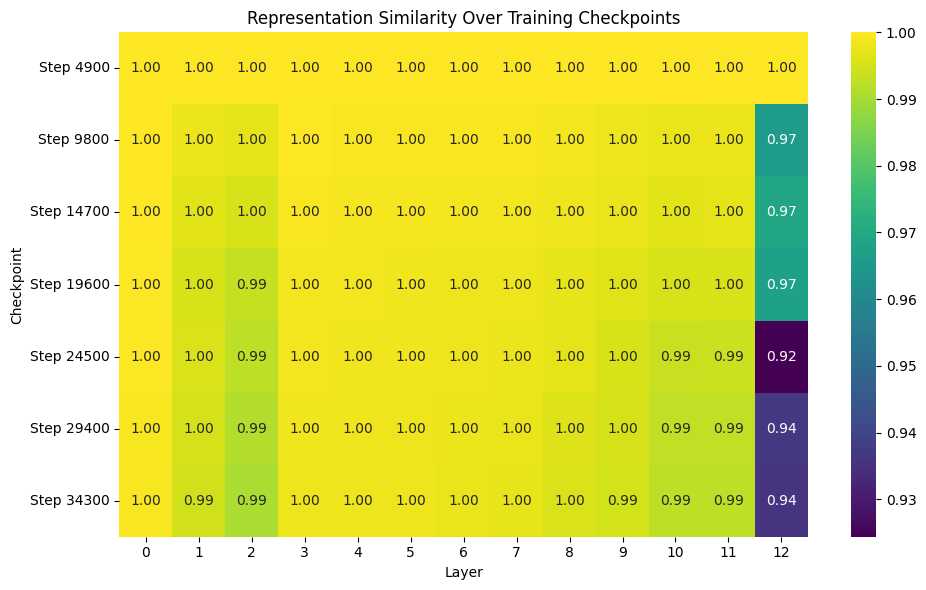

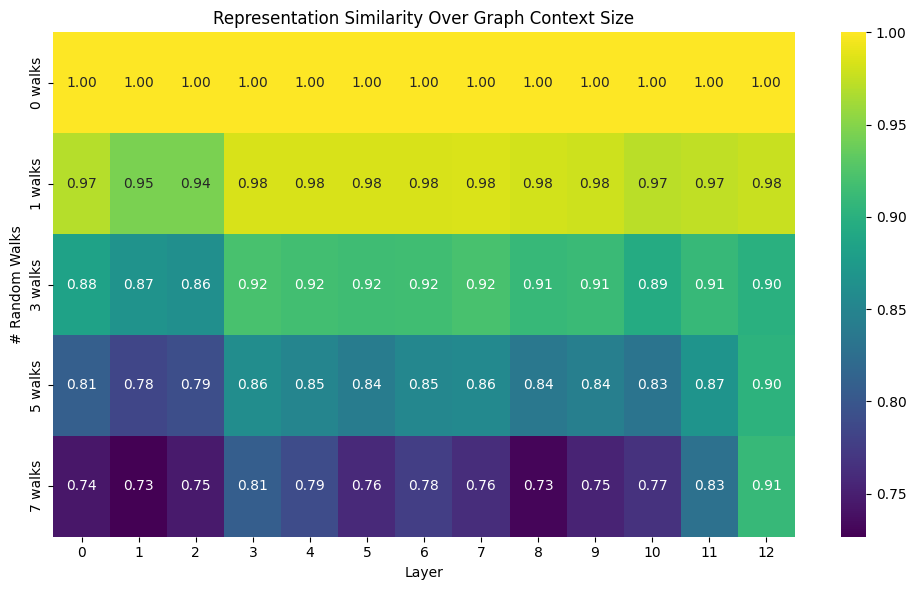

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random


checkpoint_steps = [4900, 9800, 14700, 19600, 24500, 29400, 34300]
model_base_path = "spatial_model/checkpoint-{}"
device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(42)

# query
query_prompt = "MODE: Shortest, START: apple, END: orange, PATH:"

# nodes and directions
nodes = ["apple", "banana", "cat", "dog", "elephant", "fig", "grape", "orange"]
directions = ["UP", "DOWN", "LEFT", "RIGHT"]


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def generate_random_walk(length=3):
    walk = []
    curr_node = random.choice(nodes)
    for _ in range(length):
        direction = random.choice(directions)
        next_node = random.choice(nodes)
        walk.append(f"{curr_node} {direction} {next_node}")
        curr_node = next_node
    return walk


def get_layerwise_representation(model, prompt):
    tokens = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
        return [torch.mean(layer[0], dim=0).cpu().numpy() for layer in outputs.hidden_states]


def compute_layerwise_similarity(rep_array):
    num = rep_array.shape[0]
    layers = rep_array.shape[1]
    sim_matrix = np.zeros((num, layers))
    for i in range(num):
        for j in range(layers):
            sim = cosine_similarity([rep_array[0, j]], [rep_array[i, j]])[0, 0]
            sim_matrix[i, j] = sim
    return sim_matrix


def plot_heatmap(data, title, xlabel, ylabel, xticks, yticks):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, cmap="viridis", xticklabels=xticks, yticklabels=yticks, annot=True, fmt=".2f")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# training representation similarity

reps_over_training = []

for step in checkpoint_steps:
    model = GPT2LMHeadModel.from_pretrained(model_base_path.format(step)).to(device)
    model.eval()
    rep = get_layerwise_representation(model, query_prompt)
    reps_over_training.append(rep)
    del model
    torch.cuda.empty_cache()

reps_over_training = np.array(reps_over_training)
sim_training = compute_layerwise_similarity(reps_over_training)

plot_heatmap(sim_training,
             title="Representation Similarity Over Training Checkpoints",
             xlabel="Layer", ylabel="Checkpoint",
             xticks=list(range(sim_training.shape[1])),
             yticks=[f"Step {step}" for step in checkpoint_steps])

# context representation similarity
final_step = checkpoint_steps[-1]
model = GPT2LMHeadModel.from_pretrained(model_base_path.format(final_step)).to(device)
model.eval()

num_walks_list = [0, 1, 3, 5, 7]
reps_over_context = []

for num_walks in num_walks_list:
    walks = []
    for _ in range(num_walks):
        walks += generate_random_walk(length=3)
    prompt = " ".join(walks) + " " + query_prompt
    rep = get_layerwise_representation(model, prompt)
    reps_over_context.append(rep)

reps_over_context = np.array(reps_over_context)
sim_context = compute_layerwise_similarity(reps_over_context)

plot_heatmap(sim_context,
             title="Representation Similarity Over Graph Context Size",
             xlabel="Layer", ylabel="# Random Walks",
             xticks=list(range(sim_context.shape[1])),
             yticks=[f"{n} walks" for n in num_walks_list])


In [ ]:
import os
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/cbaumgar/hf_cache"




/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))



Processing checkpoint 4900
Checkpoint 4900 - Example grid and path:


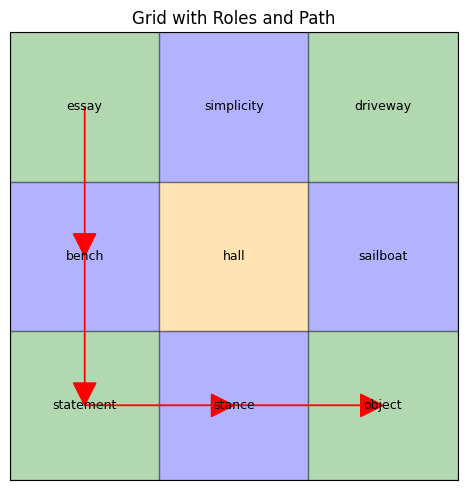


Generated Prompt:
MODE: Shortest, START: essay, END: object, PATH: essay [NA D NA R] D bench D statement R stance R object

Step 4900 - Collected 443 tokens.
Role distribution: {'edge': 211, 'center': 65, 'corner': 167}

Processing checkpoint 9800
Checkpoint 9800 - Example grid and path:


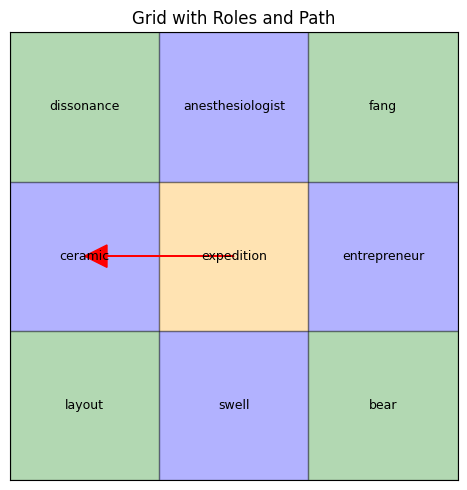


Generated Prompt:
MODE: Shortest, START: expedition, END: ceramic, PATH: expedition [U D L R] L ceramic

Step 9800 - Collected 452 tokens.
Role distribution: {'edge': 217, 'center': 68, 'corner': 167}

Processing checkpoint 14700
Checkpoint 14700 - Example grid and path:


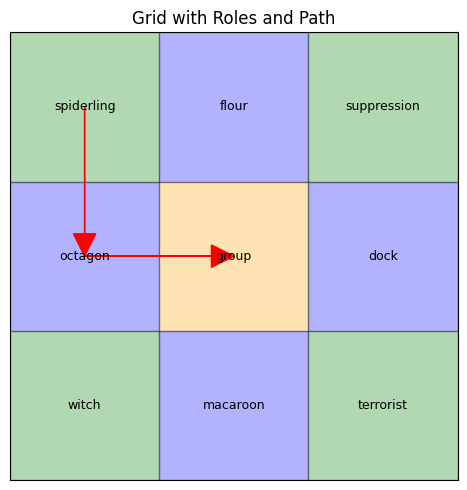


Generated Prompt:
MODE: Shortest, START: spiderling, END: group, PATH: spiderling [NA D NA R] D octagon R group

Step 14700 - Collected 457 tokens.
Role distribution: {'edge': 226, 'center': 70, 'corner': 161}

Processing checkpoint 19600
Checkpoint 19600 - Example grid and path:


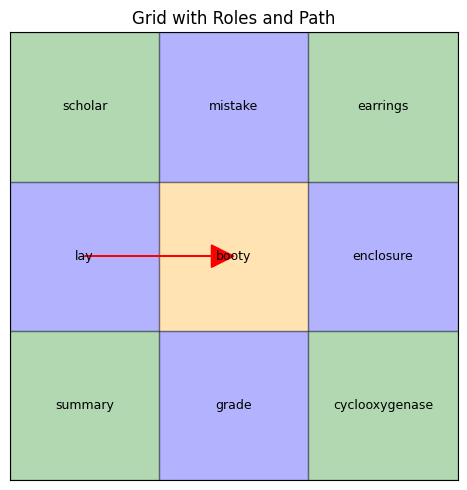


Generated Prompt:
MODE: Shortest, START: lay, END: booty, PATH: lay [U D NA R] R booty

Step 19600 - Collected 449 tokens.
Role distribution: {'edge': 216, 'center': 63, 'corner': 170}

Processing checkpoint 24500
Checkpoint 24500 - Example grid and path:


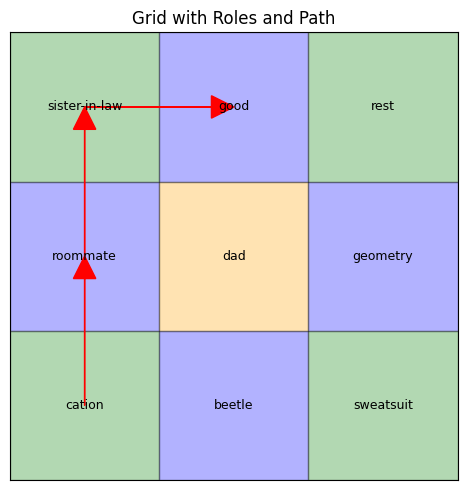


Generated Prompt:
MODE: Shortest, START: cation, END: good, PATH: cation [U NA NA R] U roommate U sister-in-law R good

Step 24500 - Collected 474 tokens.
Role distribution: {'edge': 226, 'center': 60, 'corner': 188}

Processing checkpoint 29400
Checkpoint 29400 - Example grid and path:


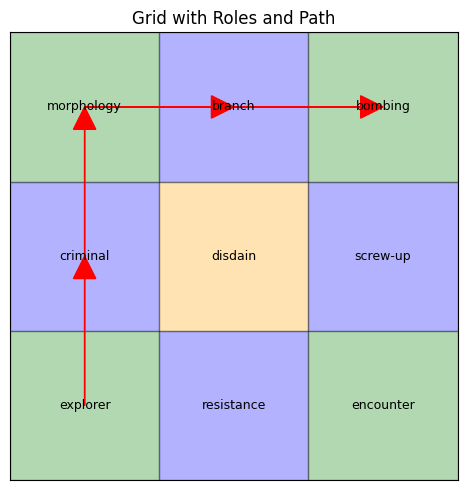


Generated Prompt:
MODE: Shortest, START: explorer, END: bombing, PATH: explorer [U NA NA R] U criminal U morphology R branch R bombing

Step 29400 - Collected 463 tokens.
Role distribution: {'edge': 223, 'center': 67, 'corner': 173}

Processing checkpoint 34300
Checkpoint 34300 - Example grid and path:


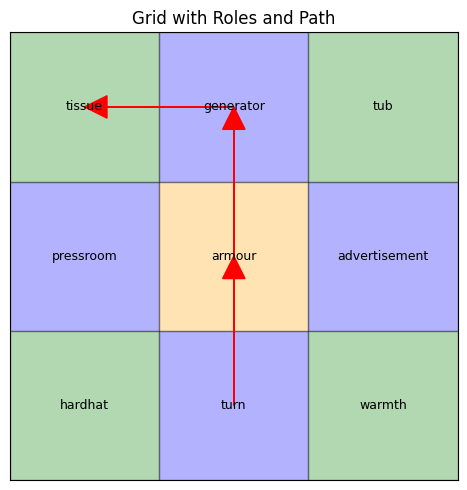


Generated Prompt:
MODE: Shortest, START: turn, END: tissue, PATH: turn [U NA L R] U armour U generator L tissue

Step 34300 - Collected 451 tokens.
Role distribution: {'edge': 215, 'center': 66, 'corner': 170}


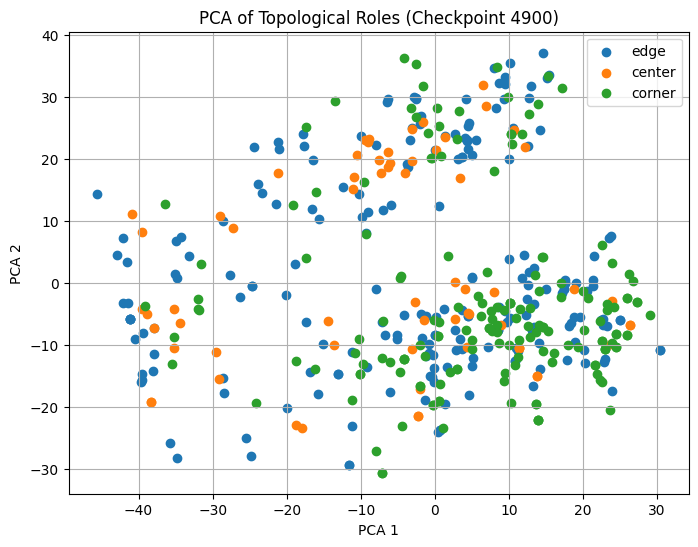

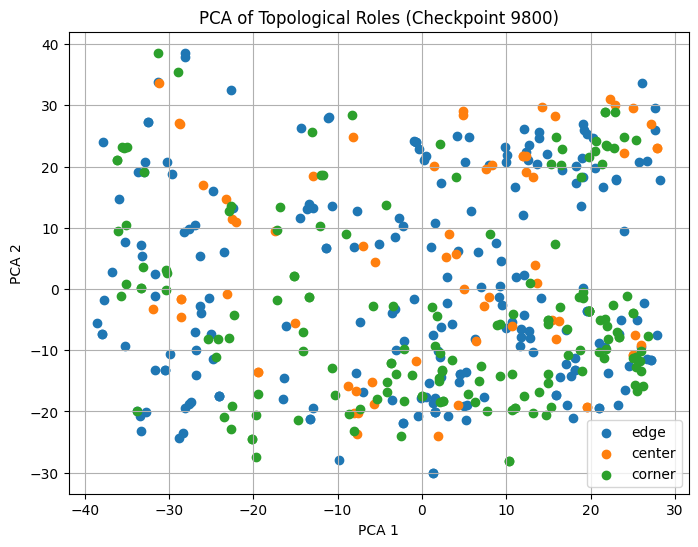

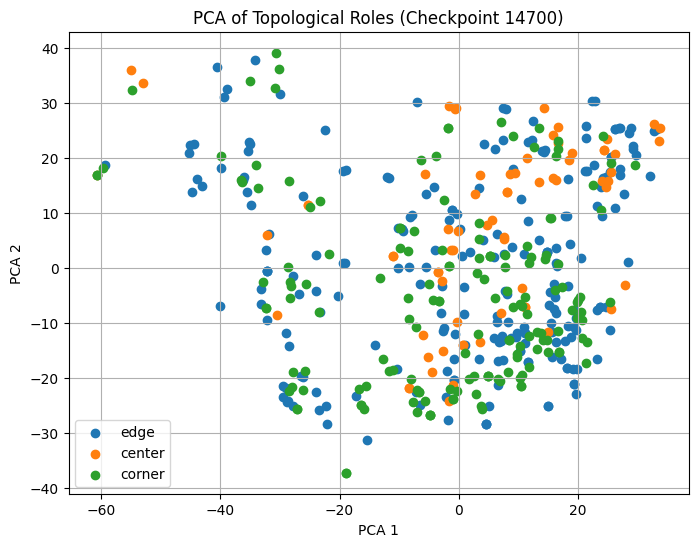

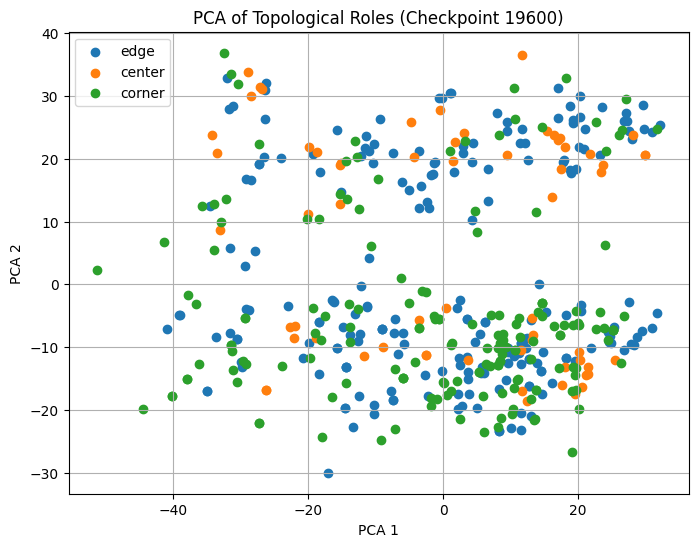

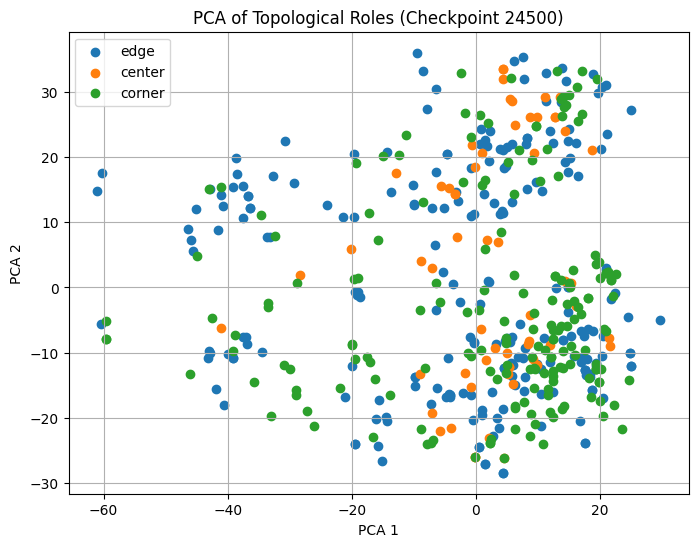

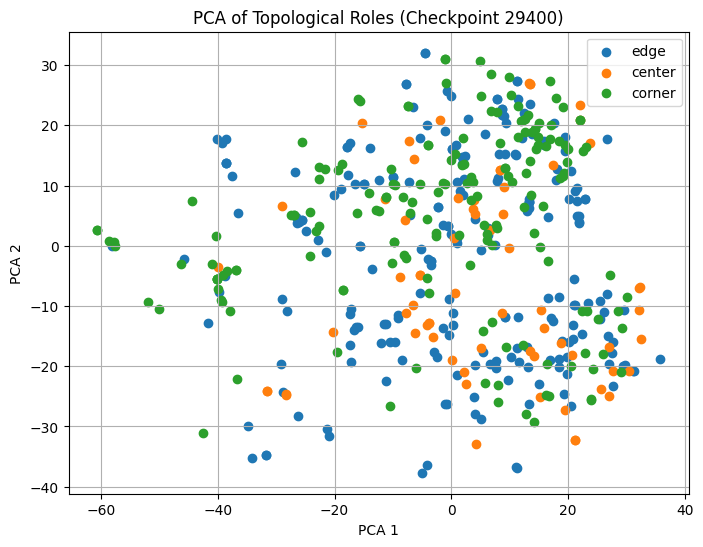

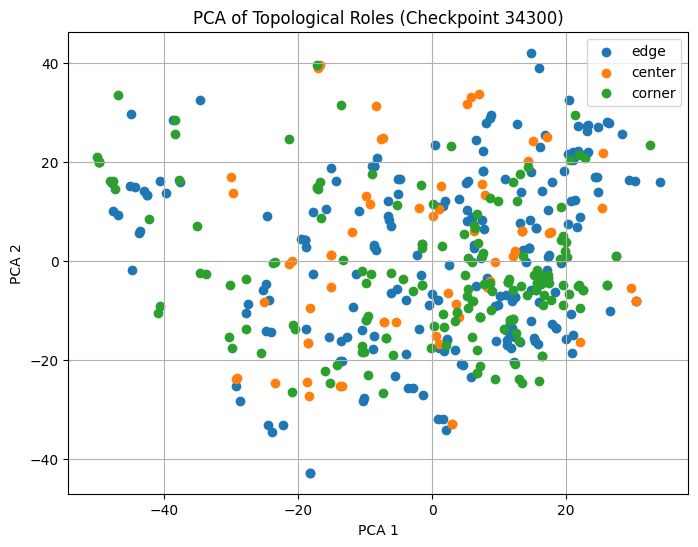


Silhouette Scores by Checkpoint:
Step 4900: 0.005
Step 9800: 0.004
Step 14700: -0.002
Step 19600: -0.001
Step 24500: 0.004
Step 29400: 0.003
Step 34300: 0.005


In [ ]:
import os
import random
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wonderwords import RandomWord
import matplotlib.patches as patches

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
grid_size = 3
prompts_per_grid = 5
checkpoints = [4900, 9800, 14700, 19600, 24500, 29400, 34300]
model_base_path = "spatial_model/checkpoint-{}"
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
Random_Word = RandomWord()

# --- Helper Functions ---
def generate_nouns(size):
    nouns = set()
    while len(nouns) < size * size:
        word = Random_Word.word(include_parts_of_speech=["nouns"]).replace(" ", "_")
        nouns.add(word)
    return list(nouns)

def create_unique_random_grid(nouns, size):
    selected = random.sample(nouns, size * size)
    return [selected[i * size:(i + 1) * size] for i in range(size)]

def get_topological_role(coord, size):
    x, y = coord
    if (x == 0 or x == size - 1) and (y == 0 or y == size - 1):
        return "corner"
    elif x == 0 or y == 0 or x == size - 1 or y == size - 1:
        return "edge"
    else:
        return "center"

def get_direction(prev, curr):
    if curr[0] == prev[0]:
        return "R" if curr[1] > prev[1] else "L"
    else:
        return "D" if curr[0] > prev[0] else "U"

def get_neighbors(coord, size):
    x, y = coord
    dirs = {"U": (x - 1, y), "D": (x + 1, y), "L": (x, y - 1), "R": (x, y + 1)}
    result = []
    for d, (nx, ny) in dirs.items():
        if 0 <= nx < size and 0 <= ny < size:
            result.append(d)
        else:
            result.append("NA")
    return f"[{' '.join(result)}]"

def generate_random_path(size):
    coords = [(i, j) for i in range(size) for j in range(size)]
    start, end = random.sample(coords, 2)
    queue = [[start]]
    while queue:
        path = queue.pop(0)
        if path[-1] == end:
            return path
        x, y = path[-1]
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < size and 0 <= ny < size and (nx, ny) not in path):
                queue.append(path + [(nx, ny)])
    return []

def generate_prompt(grid, path):
    prompt = f"MODE: Shortest, START: {grid[path[0][0]][path[0][1]]}, END: {grid[path[-1][0]][path[-1][1]]}, PATH: "
    token_coords = {}
    start_token = grid[path[0][0]][path[0][1]].lower().strip()
    prompt += start_token
    token_coords[start_token] = path[0]
    prev = path[0]
    for i in range(1, len(path)):
        curr = path[i]
        dir = get_direction(prev, curr)
        if i == 1:
            prompt += f" {get_neighbors(prev, grid_size)} {dir}"
        else:
            prompt += f" {dir}"
        word = grid[curr[0]][curr[1]].lower().strip()
        prompt += f" {word}"
        token_coords[word] = curr
        prev = curr
    return prompt, token_coords

def visualize_grid_with_roles(grid, path_coords, prompt):
    fig, ax = plt.subplots(figsize=(5, 5))
    role_colors = {"corner": "green", "edge": "blue", "center": "orange"}

    for i in range(grid_size):
        for j in range(grid_size):
            coord = (i, j)
            word = grid[i][j]
            role = get_topological_role(coord, grid_size)
            color = role_colors[role]

            rect = patches.Rectangle((j, grid_size - 1 - i), 1, 1, linewidth=1, edgecolor='black', facecolor=color, alpha=0.3)
            ax.add_patch(rect)
            ax.text(j + 0.5, grid_size - 1 - i + 0.5, word, ha='center', va='center', fontsize=9)

    for i in range(len(path_coords) - 1):
        x1, y1 = path_coords[i][1], grid_size - 1 - path_coords[i][0]
        x2, y2 = path_coords[i+1][1], grid_size - 1 - path_coords[i+1][0]
        ax.arrow(x1 + 0.5, y1 + 0.5, x2 - x1, y2 - y1, head_width=0.15, head_length=0.15, fc='red', ec='red', length_includes_head=True)

    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Grid with Roles and Path")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    print("\nGenerated Prompt:\n" + prompt + "\n")

def extract_hidden_state(prompt, token, model):
    token = token.lower().strip()
    token_start = prompt.lower().find(token)
    if token_start == -1:
        return None

    inputs = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    offset_mapping = inputs["offset_mapping"][0]

    token_index = None
    for i, (start, end) in enumerate(offset_mapping):
        if start <= token_start < end or (start == token_start and end - start == len(token)):
            token_index = i
            break

    if token_index is None:
        return None

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = output.hidden_states
        reps = torch.stack([layer[0, token_index] for layer in hidden_states[1:]])
        return reps.mean(dim=0).cpu().numpy()

# --- Main Experiment ---
silhouette_scores = {}
pca_embeddings = {}

for step in checkpoints:
    print(f"\nProcessing checkpoint {step}")
    model_path = model_base_path.format(step)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()

    reps = []
    roles = []
    plotted = False

    for _ in range(30):
        nouns = generate_nouns(grid_size)
        grid = create_unique_random_grid(nouns, grid_size)

        for _ in range(prompts_per_grid):
            path = generate_random_path(grid_size)
            if not path: continue

            prompt, token_coords = generate_prompt(grid, path)

            if not plotted:
                print(f"Checkpoint {step} - Example grid and path:")
                visualize_grid_with_roles(grid, path, prompt)
                plotted = True

            for token, coord in token_coords.items():
                role = get_topological_role(coord, grid_size)
                rep = extract_hidden_state(prompt, token, model)
                if rep is not None:
                    reps.append(rep)
                    roles.append(role)

    print(f"Step {step} - Collected {len(roles)} tokens.")
    print(f"Role distribution: {dict((r, roles.count(r)) for r in set(roles))}")

    if len(set(roles)) >= 2:
        X = np.array(reps)
        y = np.array([["corner", "edge", "center"].index(r) for r in roles])
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        pca_embeddings[step] = (X_reduced, roles)
        silhouette_scores[step] = silhouette_score(X, y)

    del model
    torch.cuda.empty_cache()

# --- Plot PCA ---
for step, (X_reduced, labels) in pca_embeddings.items():
    plt.figure(figsize=(8, 6))
    for role in set(labels):
        idxs = [i for i, r in enumerate(labels) if r == role]
        plt.scatter(X_reduced[idxs, 0], X_reduced[idxs, 1], label=role)
    plt.title(f"PCA of Topological Roles (Checkpoint {step})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Print Scores ---
print("\nSilhouette Scores by Checkpoint:")
for step, score in silhouette_scores.items():
    print(f"Step {step}: {score:.3f}")


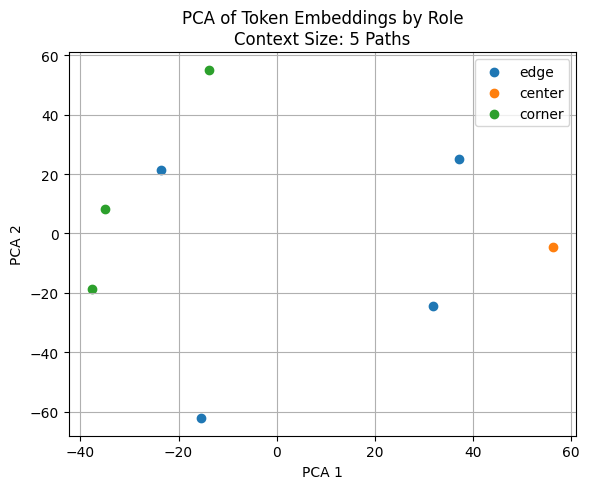

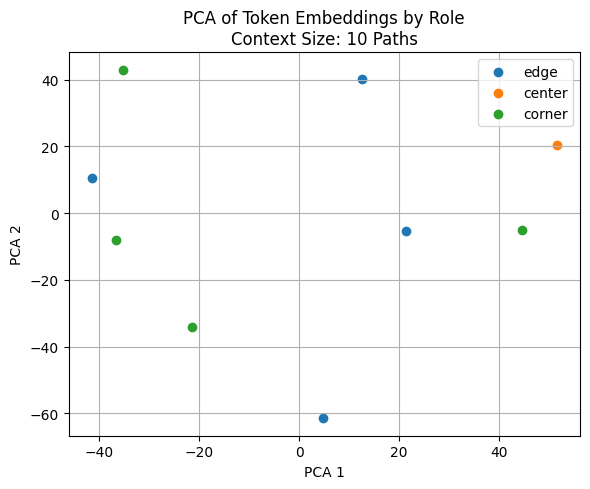

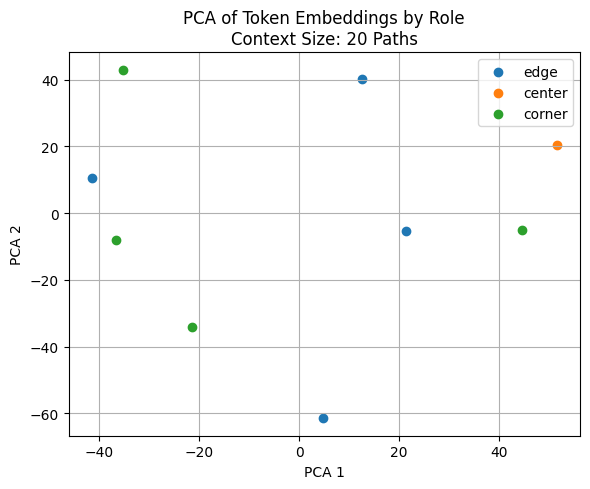

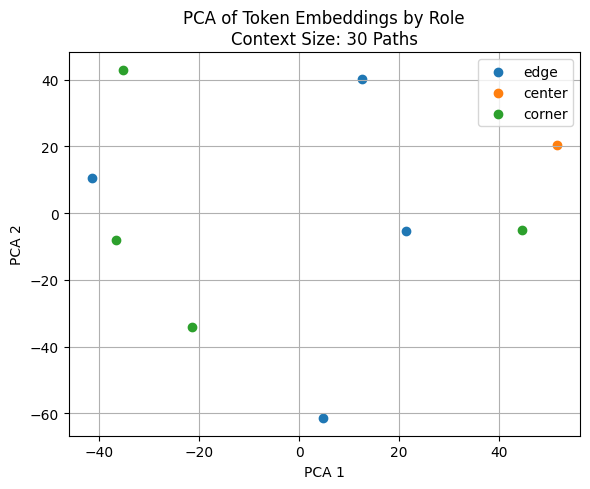

In [ ]:
# Context size experiment
## generate one grid, simulate paths along that grid, concatenate an increasing no of paths into one prompt

from collections import defaultdict


model_path = model_base_path.format(34300)
context_sizes = [5, 10, 20, 30]


model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
model.eval()


nouns = generate_nouns(grid_size)
grid = create_unique_random_grid(nouns, grid_size)

# Generate a pool of paths
all_paths = []
while len(all_paths) < max(context_sizes):
    path = generate_random_path(grid_size)
    if path:
        all_paths.append(path)

# Track noun → coord
noun_coord_map = {}
for i in range(grid_size):
    for j in range(grid_size):
        token = grid[i][j].lower().strip()
        noun_coord_map[token] = (i, j)

# experiment
for size in context_sizes:
    paths = all_paths[:size]
    full_prompt = ""
    for path in paths:
        prompt_part, _ = generate_prompt(grid, path)
        full_prompt += prompt_part + " "

    # For each noun in the grid, extract rep if present
    reps = []
    roles = []
    for token, coord in noun_coord_map.items():
        role = get_topological_role(coord, grid_size)
        rep = extract_hidden_state(full_prompt, token, model)
        if rep is not None:
            reps.append(rep)
            roles.append(role)

    if len(set(roles)) < 2:
        print(f"Context size {size}: not enough role diversity for PCA.")
        continue

    # PCA
    X = np.array(reps)
    y = np.array(roles)
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Plot
    plt.figure(figsize=(6, 5))
    for role in set(roles):
        idxs = [i for i, r in enumerate(roles) if r == role]
        plt.scatter(X_reduced[idxs, 0], X_reduced[idxs, 1], label=role)
    plt.title(f"PCA of Token Embeddings by Role\nContext Size: {size} Paths")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Processing checkpoint 4900
RSA score at step 4900: 0.308

Processing checkpoint 9800
RSA score at step 9800: -0.220

Processing checkpoint 14700
RSA score at step 14700: 0.560

Processing checkpoint 19600
RSA score at step 19600: 0.422

Processing checkpoint 24500
RSA score at step 24500: 0.031

Processing checkpoint 29400
RSA score at step 29400: 0.642

Processing checkpoint 34300
RSA score at step 34300: 0.157

RSA Scores by Checkpoint:
Step 4900: 0.308
Step 9800: -0.220
Step 14700: 0.560
Step 19600: 0.422
Step 24500: 0.031
Step 29400: 0.642
Step 34300: 0.157


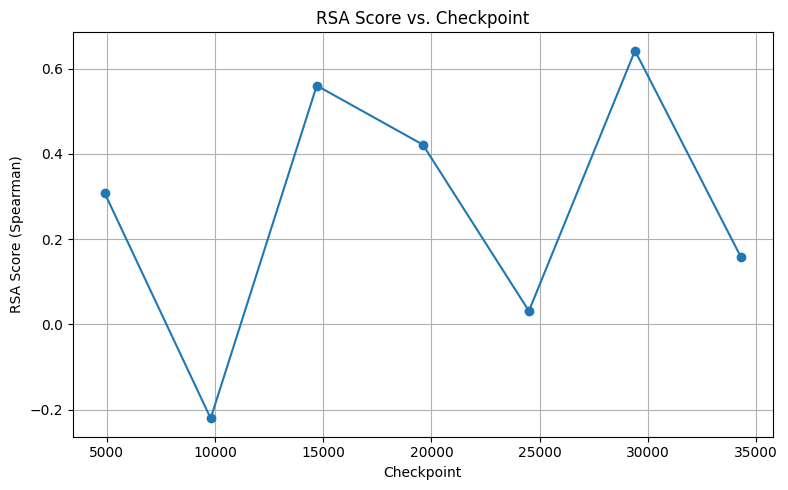

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

#### RSA BETWEEN DISTANCE MATRIX AND GROUND TRUTH (GRID COORDS)

context_variant = "medium_path"
path_length = 5



def get_topological_role(coord, size):
    x, y = coord
    if (x == 0 or x == size - 1) and (y == 0 or y == size - 1):
        return "corner"
    elif x == 0 or y == 0 or x == size - 1 or y == size - 1:
        return "edge"
    else:
        return "center"

def get_direction(prev, curr):
    if curr[0] == prev[0]:
        return "R" if curr[1] > prev[1] else "L"
    else:
        return "D" if curr[0] > prev[0] else "U"

def generate_random_path(size):
    coords = [(i, j) for i in range(size) for j in range(size)]
    start, end = random.sample(coords, 2)
    queue = [[start]]
    while queue:
        path = queue.pop(0)
        if path[-1] == end:
            return path
        x, y = path[-1]
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < size and 0 <= ny < size and (nx, ny) not in path):
                queue.append(path + [(nx, ny)])
    return []

def generate_prompt(grid, path):
    prompt = f"MODE: Shortest, START: {grid[path[0][0]][path[0][1]]}, END: {grid[path[-1][0]][path[-1][1]]}, PATH: "
    token_coords = {}
    start_token = grid[path[0][0]][path[0][1]].lower().strip()
    prompt += start_token
    token_coords[start_token] = path[0]
    prev = path[0]
    for i in range(1, len(path)):
        curr = path[i]
        dir = get_direction(prev, curr)
        if i == 1:
            prompt += f" {dir}"
        else:
            prompt += f" {dir}"
        word = grid[curr[0]][curr[1]].lower().strip()
        prompt += f" {word}"
        token_coords[word] = curr
        prev = curr
    return prompt, token_coords

def extract_hidden_state(prompt, token, model):
    token = token.lower().strip()
    token_start = prompt.lower().find(token)
    if token_start == -1:
        return None
    inputs = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    offset_mapping = inputs["offset_mapping"][0]
    token_index = None
    for i, (start, end) in enumerate(offset_mapping):
        if start <= token_start < end or (start == token_start and end - start == len(token)):
            token_index = i
            break
    if token_index is None:
        return None
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = output.hidden_states
        reps = torch.stack([layer[0, token_index] for layer in hidden_states[1:]])
        return reps.mean(dim=0).cpu().numpy()

def compute_rsa(hidden_states, coords):
    dist_model = squareform(pdist(hidden_states, metric='cosine'))
    dist_coords = squareform(pdist(coords, metric='euclidean'))
    triu_idx = np.triu_indices(len(coords), k=1)
    rsa_score, _ = spearmanr(dist_model[triu_idx], dist_coords[triu_idx])
    return rsa_score

# RSA / checkpoint
rsa_scores = {}

for step in checkpoints:
    print(f"\nProcessing checkpoint {step}")
    model_path = model_base_path.format(step)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()

    reps = []
    coords = []

    nouns = generate_nouns(grid_size)
    grid = create_unique_random_grid(nouns, grid_size)
    attempts = 0
    while True:
        path = generate_random_path(grid_size)
        if len(path) >= path_length:
            break
        attempts += 1
        if attempts > 100:
            break

    prompt, token_coords = generate_prompt(grid, path)

    for token, coord in token_coords.items():
        rep = extract_hidden_state(prompt, token, model)
        if rep is not None:
            reps.append(rep)
            coords.append(coord)

    if len(reps) > 2:
        reps = np.array(reps)
        coords = np.array(coords)
        rsa = compute_rsa(reps, coords)
        rsa_scores[step] = rsa
        print(f"RSA score at step {step}: {rsa:.3f}")

    del model
    torch.cuda.empty_cache()

# --- Print Results ---
print("\nRSA Scores by Checkpoint:")
for step, score in rsa_scores.items():
    print(f"Step {step}: {score:.3f}")

# Plot RSA trend over checkpoints
import matplotlib.pyplot as plt

steps = list(rsa_scores.keys())
scores = [rsa_scores[step] for step in steps]

plt.figure(figsize=(8, 5))
plt.plot(steps, scores, marker='o')
plt.title('RSA Score vs. Checkpoint')
plt.xlabel('Checkpoint')
plt.ylabel('RSA Score (Spearman)')
plt.grid(True)
plt.tight_layout()
plt.show()



Processing checkpoint 4900
Checkpoint 4900: RSA mean = 0.092, std = 0.303

Processing checkpoint 9800
Checkpoint 9800: RSA mean = 0.108, std = 0.299

Processing checkpoint 14700
Checkpoint 14700: RSA mean = 0.134, std = 0.332

Processing checkpoint 19600
Checkpoint 19600: RSA mean = 0.120, std = 0.309

Processing checkpoint 24500
Checkpoint 24500: RSA mean = 0.082, std = 0.309

Processing checkpoint 29400
Checkpoint 29400: RSA mean = 0.097, std = 0.307

Processing checkpoint 34300
Checkpoint 34300: RSA mean = 0.130, std = 0.322

RSA Scores by Checkpoint:
Step 4900: mean = 0.092, std = 0.303
Step 9800: mean = 0.108, std = 0.299
Step 14700: mean = 0.134, std = 0.332
Step 19600: mean = 0.120, std = 0.309
Step 24500: mean = 0.082, std = 0.309
Step 29400: mean = 0.097, std = 0.307
Step 34300: mean = 0.130, std = 0.322


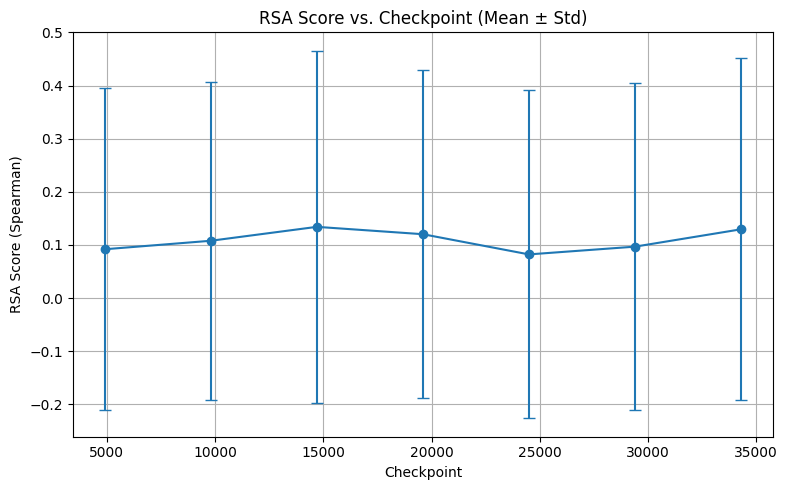

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from wonderwords import RandomWord

#### RSA BETWEEN DISTANCE MATRIX AND GROUND TRUTH (GRID COORDS)

context_variant = "medium_path"
path_length = 5
repeats = 100


# RSA / checkpoint
rsa_scores = {}

for step in checkpoints:
    print(f"\nProcessing checkpoint {step}")
    model_path = model_base_path.format(step)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()

    step_scores = []

    for _ in range(repeats):
        reps = []
        coords = []

        nouns = generate_nouns(grid_size)
        grid = create_unique_random_grid(nouns, grid_size)
        attempts = 0
        while True:
            path = generate_random_path(grid_size)
            if len(path) >= path_length:
                break
            attempts += 1
            if attempts > 100:
                break

        prompt, token_sequence, path = generate_prompt(grid, path)

        for i, token in enumerate(token_sequence):
            rep = extract_hidden_state(prompt, token, model)
            if rep is not None:
                reps.append(rep)
                coords.append(path[i])

        if len(reps) != len(coords) or len(reps) < 3:
            continue

        reps = np.array(reps)
        coords = np.array(coords)
        rsa = compute_rsa(reps, coords)
        step_scores.append(rsa)

    if step_scores:
        mean_rsa = np.mean(step_scores)
        std_rsa = np.std(step_scores)
        rsa_scores[step] = (mean_rsa, std_rsa)
        print(f"Checkpoint {step}: RSA mean = {mean_rsa:.3f}, std = {std_rsa:.3f}")

    del model
    torch.cuda.empty_cache()

# --- Print Results ---
print("\nRSA Scores by Checkpoint:")
for step, (mean, std) in rsa_scores.items():
    print(f"Step {step}: mean = {mean:.3f}, std = {std:.3f}")

# Plot RSA trend over checkpoints
steps = list(rsa_scores.keys())
means = [rsa_scores[step][0] for step in steps]
stds = [rsa_scores[step][1] for step in steps]

plt.figure(figsize=(8, 5))
plt.errorbar(steps, means, yerr=stds, fmt='-o', capsize=4)
plt.title('RSA Score vs. Checkpoint (Mean ± Std)')
plt.xlabel('Checkpoint')
plt.ylabel('RSA Score (Spearman)')
plt.grid(True)
plt.tight_layout()
plt.show()